## Import Libraries

In [81]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

%matplotlib inline

## Load the Data

In [82]:
df = pd.read_csv("./Lower Player.csv")

In [83]:
df.shape

(5912, 19)

In [84]:
df.head(2)

,Unnamed: 0,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value
0,1,Manchester United,Goalkeeper,196.0,30.0,15,0.0,0.0,0.069018,0.0,0.0,1.242331,0.207055,1304,510,58,1,1500000,22000000
1,2,Manchester United,Goalkeeper,188.0,37.0,4,0.0,0.0,0.000000,0.0,0.0,0.616438,0.924658,292,697,84,4,600000,6000000


In [85]:
df.drop(columns='Unnamed: 0' , inplace = True)


## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [86]:
# uniqeness
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value


In [87]:
# Completeness
df.isnull().sum()

team                   0
position               0
height                 0
age                    0
appearance             0
goals                  0
assists                0
yellow cards           0
second yellow cards    0
red cards              0
goals conceded         0
clean sheets           0
minutes played         0
days_injured           0
games_injured          0
award                  0
current_value          0
highest_value          0
dtype: int64

In [88]:
# Accurecy types
df.dtypes

team                    object
position                object
height                 float64
age                    float64
appearance               int64
goals                  float64
assists                float64
yellow cards           float64
second yellow cards    float64
red cards              float64
goals conceded         float64
clean sheets           float64
minutes played           int64
days_injured             int64
games_injured            int64
award                    int64
current_value            int64
highest_value            int64
dtype: object

In [89]:
# Accurecy - Outlier

# Convert categorical variables using OneHotEncoding
Cate_values = ['team' , 'position']
Num_values = ['height' , 'age' , 'appearance' , 'goals' , 'assists' , 'yellow cards' , 'second yellow cards' , 'red cards' , 'goals conceded' , 'clean sheets' , 'minutes played' , 'days_injured' , 'games_injured' , 'award' , 'current_value' , 'highest_value']

In [90]:
for i in Cate_values:
    print(df[i].value_counts())

team
Jeonbuk Hyundai Motors    46
Daejeon Hana Citizen      45
FC Seoul                  44
Gangwon FC                43
Sagan Tosu                40
                          ..
AZ Alkmaar                 3
FK Krasnodar               2
ACF Fiorentina             2
Sevilla FC                 2
CA Osasuna                 1
Name: count, Length: 371, dtype: int64
position
Defender Centre-Back          866
Goalkeeper                    787
Attack Centre-Forward         769
midfield-CentralMidfield      568
midfield-DefensiveMidfield    468
midfield-AttackingMidfield    448
Defender Right-Back           435
Attack-LeftWinger             428
Defender Left-Back            408
Attack-RightWinger            406
midfield                       74
midfield-LeftMidfield          67
midfield-RightMidfield         64
Attack                         52
Attack-SecondStriker           40
Defender                       32
Name: count, dtype: int64


In [91]:
type_counts = df['team'].value_counts()

# Filter 'Type' values that appear 10 or more times
df = df[df['team'].isin(type_counts[type_counts >= 2].index)]

In [92]:
type_counts = df['position'].value_counts()

# Filter 'Type' values that appear 10 or more times
df = df[df['position'].isin(type_counts[type_counts >= 2].index)]

#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [93]:
df.head(2)

,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value
0,Manchester United,Goalkeeper,196.0,30.0,15,0.0,0.0,0.069018,0.0,0.0,1.242331,0.207055,1304,510,58,1,1500000,22000000
1,Manchester United,Goalkeeper,188.0,37.0,4,0.0,0.0,0.000000,0.0,0.0,0.616438,0.924658,292,697,84,4,600000,6000000


In [94]:
Cate_values

['team', 'position']

In [95]:
# one hot coding
df = pd.get_dummies(df, columns=Cate_values)

In [96]:
df.shape

(5911, 402)

#### 3. Feature selection

In [97]:
# sns.heatmap(df.corr(), annot=True);

In [98]:
correlation = df.corr()
correlation['current_value'].sort_values(ascending=False)

current_value          1.000000
highest_value          0.583316
appearance             0.221549
minutes played         0.197665
award                  0.183271
                         ...   
position_Attack       -0.045307
position_midfield     -0.053952
age                   -0.054881
goals conceded        -0.079987
position_Goalkeeper   -0.113221
Name: current_value, Length: 402, dtype: float64

In [99]:
# Set the correlation threshold
threshold = 0.1  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['current_value']) > threshold]['current_value'].index
selected_features

Index(['appearance', 'goals', 'minutes played', 'days_injured',
       'games_injured', 'award', 'current_value', 'highest_value',
       'team_Arsenal FC', 'team_Borussia Dortmund', 'team_FC Barcelona',
       'team_Manchester City', 'team_Nottingham Forest',
       'team_Sociedade Esportiva Palmeiras', 'team_Wolverhampton Wanderers',
       'position_Goalkeeper'],
      dtype='object')

In [101]:
selected_features = ['appearance', 'goals', 'minutes played', 'days_injured',
       'games_injured', 'award', 'current_value', 'highest_value',
       'team_Arsenal FC', 'team_Borussia Dortmund', 'team_FC Barcelona',
       'team_Manchester City', 'team_Nottingham Forest',
       'team_Sociedade Esportiva Palmeiras', 'team_Wolverhampton Wanderers',
       'position_Goalkeeper']

In [102]:
df = df[selected_features]
df.head()

,appearance,goals,minutes played,days_injured,games_injured,award,current_value,highest_value,team_Arsenal FC,team_Borussia Dortmund,team_FC Barcelona,team_Manchester City,team_Nottingham Forest,team_Sociedade Esportiva Palmeiras,team_Wolverhampton Wanderers,position_Goalkeeper
0,15,0.000000,1304,510,58,1,1500000,22000000,False,False,False,False,False,False,False,True
1,4,0.000000,292,697,84,4,600000,6000000,False,False,False,False,False,False,False,True
2,8,0.000000,416,932,169,7,2000000,20000000,False,False,False,False,False,False,False,False
3,31,0.155575,1157,378,65,6,17000000,55000000,False,False,False,False,False,False,False,False
4,34,0.000000,1030,90,15,1,3000000,7000000,False,False,False,False,False,False,False,False


#### 4. Prepare train and test data

In [103]:
# Prepare data
X = df.drop(['current_value'], axis=1)
y = df['current_value']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)
# sacle the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [104]:
X.shape

(5911, 15)

## Buliding the Model

In [105]:
model = LinearRegression()

In [106]:
ridge_model = Ridge()

In [107]:
lasso_model = Lasso() 

In [108]:
param_grid = {
    'alpha': [0, 0.0000003, 0.0002, 0.001, 0.01, 0.5, 1, 5]  # Regularization strength
}
grid_search_ridge = GridSearchCV(estimator=ridge_model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error', 
                           verbose=1)

grid_search_lasso = GridSearchCV(estimator=lasso_model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error', 
                           verbose=1)

## Train the Model

In [109]:
# Fit the model on the training data
model.fit(X_train_scaled, y_train)

LinearRegression()

In [110]:
ridge_model.fit(X_train_scaled, y_train)

Ridge()

In [111]:
lasso_model.fit(X_train_scaled, y_train)

Lasso()

In [112]:
grid_search_ridge.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0, 3e-07, 0.0002, 0.001, 0.01, 0.5, 1, 5]},
             scoring='neg_mean_squared_error', verbose=1)

In [113]:
grid_search_lasso.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0, 3e-07, 0.0002, 0.001, 0.01, 0.5, 1, 5]},
             scoring='neg_mean_squared_error', verbose=1)

## Test the Model

In [114]:
# Predict and evaluate the model
y_pred = model.predict(X_test_scaled)

In [115]:
y_pred_ridge = ridge_model.predict(X_test_scaled)

In [116]:
y_pred_lasso = lasso_model.predict(X_test_scaled)

In [117]:
print("Best parameters found: ", grid_search_ridge.best_params_)

# Best model
best_ridge = grid_search_ridge.best_estimator_

Best parameters found:  {'alpha': 5}


In [118]:
print("Best parameters found: ", grid_search_lasso.best_params_)

# Best model
best_lasso = grid_search_lasso.best_estimator_

Best parameters found:  {'alpha': 5}


In [119]:
y_pred_ridge_cv = best_ridge.predict(X_test_scaled)

In [120]:
y_pred_lasso_cv = best_lasso.predict(X_test_scaled)

## Interpretation of the Model

In [121]:
model.coef_

array([ -63028.20675252,  132242.97845937,  259419.59469994,
         47519.68060304, -109111.53015147, -338602.20558056,
       1356408.49297825,  328667.96199922,  343752.94430348,
        203819.43604093,  -86000.00587116,  147061.30483652,
        238570.60868874,  175877.25762161, -119761.42543832])

In [122]:
coeff_df = pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
appearance,-6.302821e+04
goals,1.322430e+05
minutes played,2.594196e+05
days_injured,4.751968e+04
games_injured,-1.091115e+05
award,-3.386022e+05
highest_value,1.356408e+06
team_Arsenal FC,3.286680e+05
team_Borussia Dortmund,3.437529e+05
team_FC Barcelona,2.038194e+05


In [123]:
coeff_df = pd.DataFrame(best_lasso.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
appearance,-6.297723e+04
goals,1.322362e+05
minutes played,2.593740e+05
days_injured,4.740740e+04
games_injured,-1.089962e+05
award,-3.385941e+05
highest_value,1.356392e+06
team_Arsenal FC,3.286623e+05
team_Borussia Dortmund,3.437492e+05
team_FC Barcelona,2.038156e+05


In [124]:
coeff_df = pd.DataFrame(ridge_model.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
appearance,-6.259966e+04
goals,1.322045e+05
minutes played,2.590525e+05
days_injured,4.704970e+04
games_injured,-1.085657e+05
award,-3.383265e+05
highest_value,1.355908e+06
team_Arsenal FC,3.286147e+05
team_Borussia Dortmund,3.437046e+05
team_FC Barcelona,2.038286e+05


In [125]:
coeff_df = pd.DataFrame(best_ridge.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
appearance,-6.090116e+04
goals,1.320517e+05
minutes played,2.575982e+05
days_injured,4.521738e+04
games_injured,-1.064318e+05
award,-3.372259e+05
highest_value,1.353916e+06
team_Arsenal FC,3.284021e+05
team_Borussia Dortmund,3.435107e+05
team_FC Barcelona,2.038646e+05


In [126]:
print(model.intercept_) 

1151143.1895093063


## Evaluating the Model 

1. Mean Square Error For Very Model

In [127]:
y_base = [y_train.mean()] * len(y_test)

In [128]:
# our benchmark model
mse_base = mean_squared_error(y_test, y_base )
print(f'Mean Squared Error of base model: {mse_base}')

Mean Squared Error of base model: 5492443031502.974


In [129]:
mse_train = mean_squared_error(y_train, model.predict(X_train_scaled))
mse_test = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error for training: {mse_train}')
print(f'Mean Squared Error for testing: {mse_test}')

Mean Squared Error for training: 3017089071101.799
Mean Squared Error for testing: 4001552764256.4995


In [130]:
mse_train_ridge = mean_squared_error(y_train, best_ridge.predict(X_train_scaled))
mse_test_ridge = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error for training: {mse_train_ridge}')
print(f'Mean Squared Error for testing: {mse_test_ridge}')

Mean Squared Error for training: 3017094486649.318
Mean Squared Error for testing: 4001552764256.4995


In [131]:
mse_train_lasso = mean_squared_error(y_train, best_lasso.predict(X_train_scaled))
mse_test_lasso = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error for training: {mse_train_lasso}')
print(f'Mean Squared Error for testing: {mse_test_lasso}')

Mean Squared Error for training: 3017089073096.856
Mean Squared Error for testing: 4001552764256.4995


2. Mean Absolute Error For Every Model

In [132]:
# our benchmark model
mse_base = mean_absolute_error(y_test, y_base )
print(f'Mean Absolute  Error of base model: {mse_base}')

Mean Absolute  Error of base model: 1211114.4028917847


In [133]:
mae_train = mean_absolute_error(y_train, model.predict(X_train_scaled))
mae_test = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error for training: {mae_train}')
print(f'Mean Absolute Error for testing: {mae_test}')

Mean Absolute Error for training: 874306.1823122592
Mean Absolute Error for testing: 935218.5300878213


In [134]:
mae_train_ridge = mean_absolute_error(y_train, best_ridge.predict(X_train_scaled))
mae_test_ridge = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error for training: {mae_train_ridge}')
print(f'Mean Absolute Error for testing: {mae_test_ridge}')

Mean Absolute Error for training: 874316.8723403655
Mean Absolute Error for testing: 935218.5300878213


In [135]:
mae_train_lasso = mean_absolute_error(y_train, best_lasso.predict(X_train_scaled))
mae_test_lasso = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error for training: {mae_train_lasso}')
print(f'Mean Absolute Error for testing: {mae_test_lasso}')

Mean Absolute Error for training: 874304.922244735
Mean Absolute Error for testing: 935218.5300878213


3. Root Mean Squared Error For Every Model

In [136]:
# our benchmark model
print(f'Root Mean Squared  Error of base model: {np.sqrt(mse_base)}')

Root Mean Squared  Error of base model: 1100.506430191021


In [137]:
print(f'Root Mean Squared Error for training: {np.sqrt(mse_train)}')
print(f'Root Mean Squared Error for testing: {np.sqrt(mse_test)}')

Root Mean Squared Error for training: 1736976.9921049038
Root Mean Squared Error for testing: 2000388.1533983597


In [138]:
print(f'Root Mean Squared Error for training: {np.sqrt(mse_train_ridge)}')
print(f'Root Mean Squared Error for testing: {np.sqrt(mse_test_ridge)}')

Root Mean Squared Error for training: 1736978.551004392
Root Mean Squared Error for testing: 2000388.1533983597


In [139]:
print(f'Root Mean Squared Error for training: {np.sqrt(mse_train_lasso)}')
print(f'Root Mean Squared Error for testing: {np.sqrt(mse_test_lasso)}')

Root Mean Squared Error for training: 1736976.9926791938
Root Mean Squared Error for testing: 2000388.1533983597


4. R Square For every Model

In [140]:
r2_score_train = r2_score(y_train, model.predict(X_train_scaled))
r2_score_test = r2_score(y_test, y_pred)
print(f'R Square for training: {r2_score_train}')
print(f'R Square for testing: {r2_score_test}')

R Square for training: 0.434111036872147
R Square for testing: 0.271402624267561


In [141]:
r2_score_train = r2_score(y_train, best_ridge.predict(X_train_scaled))
r2_score_test = r2_score(y_test, y_pred)
print(f'R Square for training: {r2_score_train}')
print(f'R Square for testing: {r2_score_test}')

R Square for training: 0.4341100211253467
R Square for testing: 0.271402624267561


In [142]:
r2_score_train = r2_score(y_train, best_lasso.predict(X_train_scaled))
r2_score_test = r2_score(y_test, y_pred)
print(f'R Square for training: {r2_score_train}')
print(f'R Square for testing: {r2_score_test}')

R Square for training: 0.4341110364979517
R Square for testing: 0.271402624267561


#### Predictions vs. Real Values

In [143]:
predictions = model.predict(X_test_scaled)

In [144]:
predictions_ridge = best_ridge.predict(X_test_scaled)

In [145]:
predictions_lasso = best_lasso.predict(X_test_scaled)

In [146]:
Real_Values = np.array(y_test)
#Real_Values

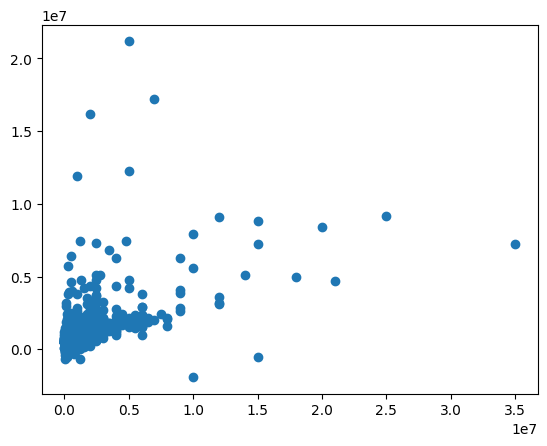

In [147]:
plt.scatter(Real_Values,predictions); 

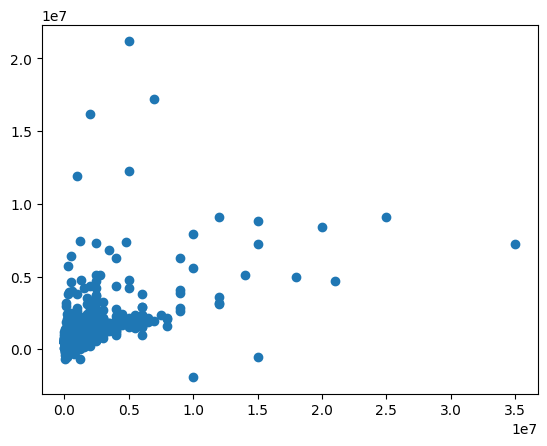

In [148]:
plt.scatter(Real_Values,predictions_ridge); 

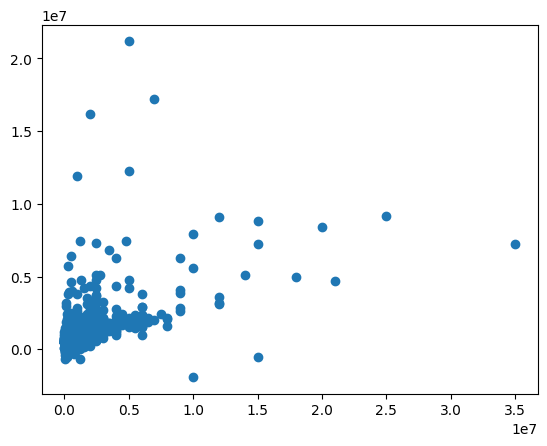

In [149]:
plt.scatter(Real_Values,predictions_lasso); 

#### Residual Histogram

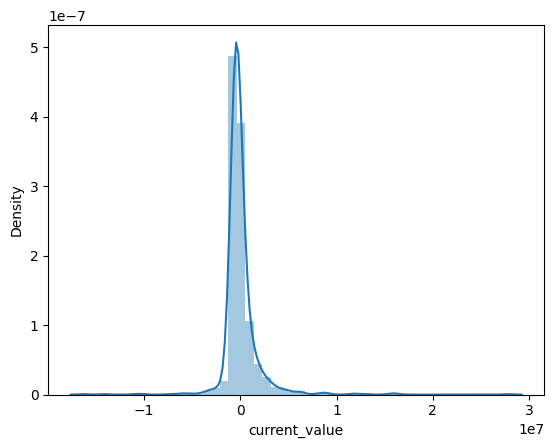

In [150]:
sns.distplot((y_test-predictions),bins=50); # it's good if we get normal distribution

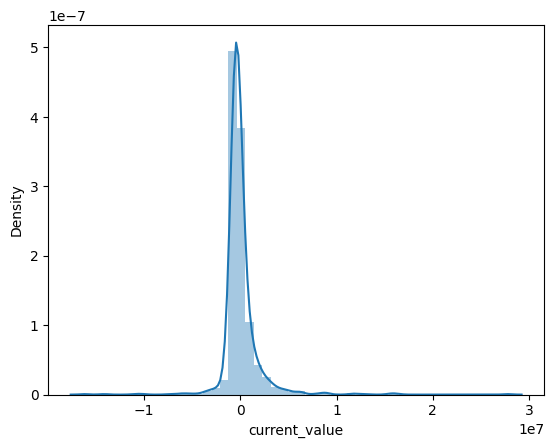

In [151]:
sns.distplot((y_test-predictions_ridge),bins=50);

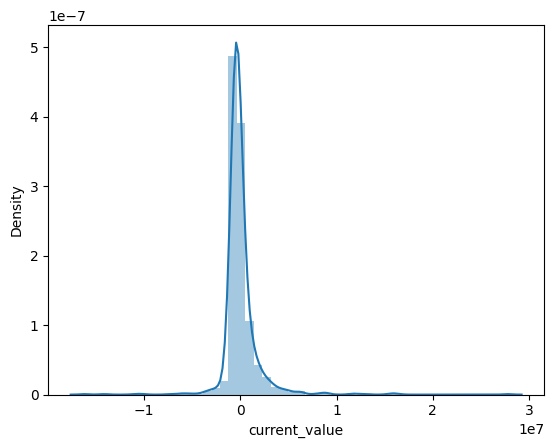

In [152]:
sns.distplot((y_test-predictions_lasso),bins=50);